In [1]:
from sys import path
from os.path import relpath, realpath, abspath, join, exists
from itertools import product

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py

pd.set_option('display.max_rows', 999)

In [2]:
from torchnetjson.builder import build_net

In [3]:
from thesis_v2 import dir_dict
from thesis_v2.data import load_data_helper
from thesis_v2.training.training_aux import load_training_results
from thesis_v2.training_extra.misc import count_params
from thesis_v2.models.maskcnn_polished.builder import load_modules

load_modules()

In [4]:
folder_to_check = 'scripts/training/yuanyuan_8k_a_3day/maskcnn_polished'
path.insert(0, join(dir_dict['root'], folder_to_check))
from submit import param_iterator_obj
from key_utils import keygen

In [5]:
def load_everything():
    _df_collect = []
    for idx, param in enumerate(param_iterator_obj.generate()):
        if idx % 50 == 0:
            print(idx)
        
        assert len(param) == 16
#         assert param['split_seed'] == 'legacy'
        assert param['out_channel'] == 16
        assert param['num_layer'] == 2
        assert param['kernel_size_l1'] == 9
        assert param['pooling_ksize'] == 3
        assert param['pooling_type'] == 'avg'
        
        assert param['model_seed'] == 0
        
        key = keygen(**{k: v for k, v in param.items() if k not in {'scale', 'smoothness'}})
        # 10 to go.
        result = load_training_results(key, return_model=False)
        # load twice, first time to get the model.
        result = load_training_results(key, return_model=True, model=build_net(result['config_extra']['model']))
        num_epochs = [len(x) for x in result['stats_all']]
        _df_collect.append(
            {
                'split_seed': str(param['split_seed']),
                
                
                'act_fn': param['act_fn'],
                'bn_before_act': param['bn_before_act'],
                'bn_after_fc': param['bn_after_fc'],
                'input_size': param['input_size'],
                'loss_type': param['loss_type'],
                
                # 5 to go
                
                'scale': float(param['scale']),
                # 
                'smoothness': float(param['smoothness']),
                # 
                
                # 1 to go
                
                
#                 'model_seed': param['model_seed'],
                'corr_test': result['stats_best']['stats']['test']['corr_mean'],
#                 'max_epoch': max(num_epochs),
#                 'num_param': count_params(result['model']),
            }
        )
        _df =  pd.DataFrame(_df_collect, columns=['split_seed', 'act_fn', 'bn_before_act', 'bn_after_fc',
                                                  'input_size', 'loss_type', 'scale',
                                                  'smoothness',
#                                                   'model_seed',
                                                  'corr_test',
#                                                   'num_param',
#                                                   'max_epoch',
                                                 ])
        _df = _df.set_index(['split_seed', 'act_fn', 'bn_before_act', 'bn_after_fc',
                             'input_size', 'loss_type', 'scale',
                             'smoothness',
#                              'model_seed',
                            ],verify_integrity=True)['corr_test']
    return _df

In [6]:
# collect all data.
# it's a series.
df = load_everything()

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150


In [7]:
# only focus on the split seed == 'legacy' part.

In [8]:
# df_to_use = df.xs('legacy', level='split_seed')
df_to_use = df

In [9]:
# also, remove bn_before_act, as this is not investigated in Plos paper; this actually makes my argument difficult,
# as bn_before_act=False is actually a little better. so just remove it
df_to_use = df_to_use.xs(False, level='bn_before_act')

In [10]:
df_to_use

split_seed  act_fn    bn_after_fc  input_size  loss_type  scale  smoothness
legacy      softplus  False        50          poisson    0.010  0.000005      0.509671
                                                                 0.000050      0.503833
                                                                 0.000500      0.458801
                                                                 0.005000      0.374587
                                                          0.001  0.000005      0.486486
                                                                 0.000050      0.503359
                                                                 0.000500      0.460643
                                                                 0.005000      0.416883
                                                          0.100  0.000005      0.508710
                                                                 0.000050      0.508961
                                            

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

from thesis_v2.plots.basic import scatter

In [12]:
def plot_scatter(df_this, key1, key2, level, xlabel, ylabel):
    fig, ax = plt.subplots(figsize=(6,5))
    
    x = df_this.xs(key1, level=level).sort_index().values
    y = df_this.xs(key2, level=level).sort_index().values
    
    scatter(ax, x, y, xlabel, ylabel)
    plt.show()
    print('N', x.size)

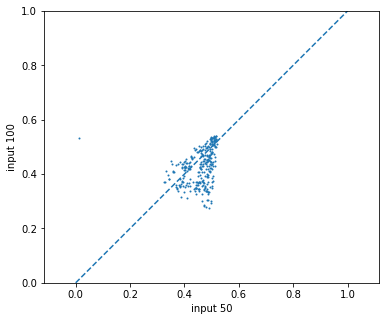

N 288


In [13]:
plot_scatter(df_to_use, 50, 100, 'input_size', 'input 50', 'input 100')
# os let's forget about the 50 one. just ignore that for now.

In [14]:
df_to_use = df_to_use.xs(100, level='input_size')

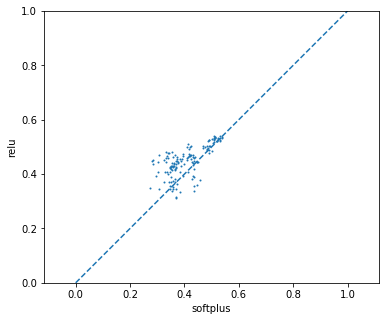

N 144


In [15]:
plot_scatter(df_to_use, 'softplus', 'relu', 'act_fn', 'softplus', 'relu')

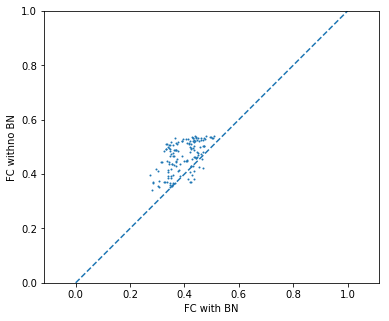

N 144


In [16]:
plot_scatter(df_to_use, True, False, 'bn_after_fc', 'FC with BN', 'FC withno BN')

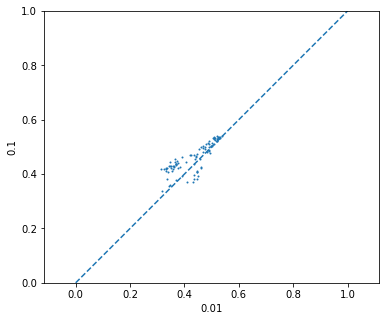

N 96


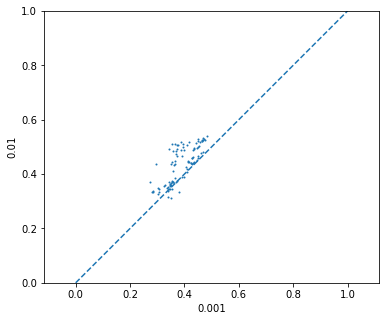

N 96


In [17]:
# scale
# no need to be shown in the paper.
plot_scatter(df_to_use, 0.01, 0.1, 'scale', '0.01', '0.1')  # similar.
plot_scatter(df_to_use, 0.001, 0.01, 'scale', '0.001', '0.01')  # 0.01 is better.

In [18]:
# smoothness has been examined before. no need.

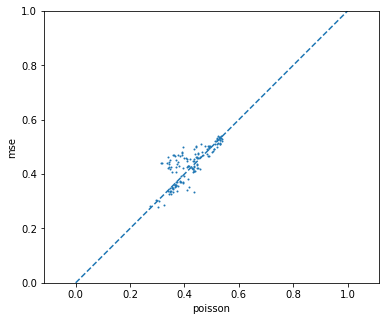

N 144


In [19]:
# loss_type
plot_scatter(df_to_use, 'poisson', 'mse', 'loss_type', 'poisson', 'mse')